![MLTrain logo](https://mltrain.cc/wp-content/uploads/2017/11/mltrain_logo-4.png "MLTrain logo")

---------------------------------------------------------

In [4]:
# !wget -q -O retailer.csv https://raw.githubusercontent.com/cmalliopoulos/PfBDAaML/master/retailer.csv

In [1]:
%run changeNBLayout.py

--------------------------
# Scope #

A large retailer asked for insights on consumer purchasing preferences in their __fluid__ products.  
Fluids are products like shampoo, conditioner and cleaning liquids that are offered in packs of different sizes (weights | volumes).  
In particular, the retailer wanted to know  
1. the effects of promos on sales
2. the consequences of __introducing a new size for a fluid product__

In the project we will investigate the effect of the <span style = "color: darkred">size composition of a sort</span> to __sort sales__.
A _sort_ is a collection of product items (SKUs) differing only in their sizes.

### An example of sort composition ###
A type of H&S Shampoo if available in ounce-sizes 7 and 12. If I introduce a size 16oz what will be the effect on total H&S sales?


# The retailer dataset #

The dataset contains numbers of items sold per week and store for each SKU.  
SKUs belong to BRANDS, SEGMENTS, TYPES and COLLECTIONS

In [3]:
import pandas as pd
import numpy as np
import sys, os
import datetime as dt

from os import linesep as endl

pd.set_option('display.width', 170)

tab = pd.read_csv('retailer.csv', sep = '|')
print tab.sample(10)

          SKU    GEO WEEK_ENDING  WEEK  MONTH  PCT  PCTF  PCTD  UNITS   REVENUE SEGMENT TYPE BRAND COLLECTION  SORT          BASE_ITEM SIZE
58761  102336  TTCTA  1982-10-14    41     10  100     0     2   5981  17124.24     CON   CR     S       SNRM   863     REG 1CT 28.0OZ    D
54610  100323  TWTUC  1985-07-18    29      7   97     0     2  11754  23253.27     CON   CR     S       SNRM   863     REG 1CT 12.6OZ    C
94082  102009  TTCTA  1984-05-03    18      5   76     0     1   1400   5582.00     SHA   SD     S        SPK  1037   TREAT KRTN 4.3OZ    A
474    103790  PTCTA  1984-08-02    31      8   86     0     0    713   5336.29     SHA   SR   H&S      H&SCC   357     REG 1CT 23.7OZ    D
58063  103099  TTCTA  1982-08-12    32      8  100     0     0   7469  21407.13     SHA   SR     S       SNRM   862     REG 1CT 28.0OZ    D
99033  101142  TTCTA  1986-05-08    19      5   63     0     1   2057   6039.80     SHA   SR     S        SPC  1097     REG 1CT 12.6OZ    C
62487  100770  TWTUC

How about the types of the data?

In [4]:
tab.dtypes

SKU              int64
GEO             object
WEEK_ENDING     object
WEEK             int64
MONTH            int64
PCT              int64
PCTF             int64
PCTD             int64
UNITS            int64
REVENUE        float64
SEGMENT         object
TYPE            object
BRAND           object
COLLECTION      object
SORT             int64
BASE_ITEM       object
SIZE            object
dtype: object

Everything seems to have been read properly exept from WEEK_ENDING.  
It is a date column but has been read as string (type 'object' in DataFrames)

We can either re-read retailer.csv and explicitly parse WEEK_ENDING as date:
``` Python
pd.read_csv('retailer.csv', sep = '|', parse_dates = ['WEEK_ENDING'])
```
or we can convert the WEEK_ENDING column to datetime type using pandas.to_datetime function:

In [5]:
tab.WEEK_ENDING = pd.to_datetime(tab.WEEK_ENDING, format = '%Y-%m-%d')
print tab.WEEK_ENDING.dtype

datetime64[ns]


`DateFrame.describe` computes basic descriptive statistics of tab's contents

In [6]:
print tab.describe()

                 SKU           WEEK          MONTH            PCT           PCTF           PCTD          UNITS        REVENUE           SORT
count  112779.000000  112779.000000  112779.000000  112779.000000  112779.000000  112779.000000  112779.000000  112779.000000  112779.000000
mean   102751.378555      24.961908       6.181816      68.333254       4.534337       2.186657    5576.052102   19103.393757     689.939173
std      1504.111777      14.524046       3.341917      31.977284      16.358580       5.421718    8459.402683   25958.044088     289.565226
min    100009.000000       1.000000       1.000000       1.000000       0.000000       0.000000       5.000000       1.270000     356.000000
25%    101462.000000      13.000000       3.000000      48.000000       0.000000       0.000000     638.000000    2676.925000     385.000000
50%    102862.000000      24.000000       6.000000      81.000000       0.000000       0.000000    2539.000000   11185.930000     842.000000
75%    103837

-------------------------------------------------------
# An analysis of attribute relations #

There're several attributes that classify SKUs: SEGMENT, TYPE, BRAND, COLLECTION, SORT and BASE_ITEM  
We want to see if subsets of the attributes constitute dimension hierarchies.  
A dimension hierarchy is a set of attributes with a 1:N relation between them.  
  
E.g. if SEGMENT, BRAND, COLLECTION constitute a dimension hierarchy then SEGMENT:BRAND and BRAND:COLLECTION should be 1:N relations  

We can search for such relations per case, i.e search for a 1:N relation between SEGMENT and BRAND:

<span style = "color: darkred; font-size: 200%; font-weight: bold;  text-decoration: underline"> 
Exercise 
</span>

Do SEGMENT and BRAND constitute a dimension hierarchy?


Doing so explicitly for each pair of attributes in datasets with even a moderate number of attributes, is cumbersome and _leads to errors_.  
Instead, let's use Python's expressiveness to construct a representation of relations with a few lines of code:

In [7]:
def cardinals(df_):
    ret = pd.DataFrame(
        data = [], 
        index = pd.MultiIndex.from_product([df_.columns] * 2, names = ['groupby', '']),
        columns = ['nunique'])
    for row in df_.columns:
        ret.loc[row] = np.array([df_.groupby(row)[col].nunique().max() for col in df_.columns]).reshape(-1, 1)
    return ret.unstack()


print cardinals(tab[['SEGMENT', 'TYPE', 'BRAND', 'COLLECTION']])

           nunique                        
             BRAND COLLECTION SEGMENT TYPE
groupby                                   
BRAND            1         37       2    6
COLLECTION       1          1       2    5
SEGMENT          4         99       1    5
TYPE             4         76       1    1


In one stroke we see that BRAND:COLLECTION and SEGMENT:TYPE are dimension hierarchies

----------------------------------------------------------
# Creation of SIZE-related attributes #
The object is to see if the size composition of a SORT is related to total SORT sales.  
We must therefore create proxies of a sort's SIZE composition.
  
__SIZE_NUM__ = number of distinct sizes per GEO, WEEK_ENDING, SORT  
__SIZE_SORT__ = A (sorted) string representation of the available sizes per WEEK_ENDING, GEO, SORT
  
the second attribute tells us not only how many SIZEs we have for each SORT a given week but also the __kinds__ of available sizes:  
e.g. for SIZE_NUM = 3 we can have SIZE_SORT = 'ABC' or 'BDE'. These 2 sorts are not the same.

In [8]:
tab['NUM_SIZE'] = tab.groupby(['SORT', 'GEO', 'WEEK_ENDING'])['SIZE'].transform('nunique')
print tab[tab['NUM_SIZE'] > 1][['SORT', 'GEO', 'WEEK_ENDING', 'NUM_SIZE']].sample(10)

       SORT    GEO WEEK_ENDING  NUM_SIZE
13570   371  TWTUC  1985-11-07         2
73369   930  PTCTA  1984-08-02         2
3598    357  TWTUC  1983-09-08         4
23406   385  TWTUC  1985-01-03         2
8337    361  TTCTA  1985-11-14         3
24289   385  TTCTA  1986-03-27         2
81474   980  TWTUC  1985-10-03         2
99674  1098  TTCTA  1986-02-06         2
80583   972  TWTUC  1982-04-01         2
72888   928  TTCTA  1983-09-08         2


`transform` is a convenience DataFrame method similar to `partition by` clauses in SQL.  
Applies a group transform to each row in the dataset, thereby creating new group columns  
  
------------------------
`SIZE_SORT` is trickier:  
We must gather the unique SIZES per SORT, concatenate them to create a string, than apply this string to each `['WEEK_ENDING', 'GEO', 'SORT']` group using `transform`.  
  
Fortunately Pandas is quite flexible in this (although not higly performant as you'll see), by permitting __custom functions in transformations__

In [9]:
%%timeit -n1 -r1
asSortedString = lambda _: ''.join(np.unique(_))

tab['SIZE_SORT'] = (tab.
    groupby(['WEEK_ENDING', 'GEO', 'SORT']).
    SIZE.
    transform(asSortedString))

1 loop, best of 1: 13.4 s per loop


In [10]:
print 'First column not shown'
print tab[tab.columns[3:]].sample(10)

First column not shown
       WEEK  MONTH  PCT  PCTF  PCTD  UNITS   REVENUE SEGMENT TYPE BRAND COLLECTION  SORT          BASE_ITEM SIZE  NUM_SIZE SIZE_SORT
56557     8      2   54     0     0   1188   4657.36     SHA   SR     S      SNA&S   860     REG 1CT 28.0OZ    D         2        CD
81644    45     11   90     0     0   2635   7627.64     CON   CR     S        SPK   931     REG 1CT 28.0OZ    D         2        CD
19977     7      2   94     0     0   1918  14985.92     SHA   SR   H&S      H&SIS   377     REG 1CT 23.7OZ    D         1         D
80917    21      5   72     0     8   1947   9577.44     CON   CR     S        SPM   972     REG 1CT 28.0OZ    D         2        CD
99543    11      3   66     0     0   3070   8813.86     CON   CR     S        SPC  1098     REG 1CT 12.6OZ    C         2        CD
37031    50     12    3     0     0      9     34.81     SHA   SR   H&S     H&SMES   397     REG 1CT 13.5OZ    C         1         C
45935    27      7   94     0     0   1428   7

<p>
<span style = "color: darkred; font-size: 200%; font-weight: bold;  text-decoration: underline"> 
Exercise
</span></p>  
Another interesting issue is the dependency a SORT may have on the number of __possible__ sizes in the SORT. E.g. assume that a product has 5 possible SIZES and 2 are only available in a given week.  
Is the effect on sales the same as having 2 sizes for a product with 2 possible sizes?  
  
Create an attribute called PCT_SIZE per GEO, WEEK_ENDING, SORT that contains the percentage of available sizes with respect to the total number of sizes available for the SORT

-------------------------------------------------------------------------------------------
# Creation of UNITS and REVENUE related attributes #

### UNITS ###
The way retailer.csv provides the items sold per GEO and WEEK_ENDING (UNITS field) is cumbersome:  
  
1. GEO is not a store's location but a the name of a distribution channel!  
2. UNITS is therefore the number of SKUs sold through a channel's stores (channels have different number of stores).  
3. There is no indication of the number of stores per channel. Rather the field PCT contains the __percentage__ of the stores in a channel that a given SKU was available in a certain WEEK_ENDING.  
  
The best we can do is assume that each channel has 100 stores and use the UNITS/PCT as a target variable in our prediction task.  
We can say that we predict the units sold per GEO's __percentile store__.  
  
We use Dataframe's `where` method to divide UNITS by non-zero PCT only

In [11]:
# DO NOT forget to convert to float:
# Both UNITS and PCT are int. Dividing them in Python 2.x produces an int that will truncate fractional sales

tab['SALES'] = np.where(tab.PCT > 0, (1. * tab.UNITS)/tab.PCT, 0.) 
print tab.SALES.dtype

float64


### REVENUE ###
REVENUE contains the pounds collected from ALL the stores of the channel per SKU and WEEK_ENDING.  
Therefore is not sth that we can use during the prediction phase (we don't know the items sold).  
  
REVENUE/UNITS however is the avg selling price of the item and this is known during the prediction phase.

In [12]:
tab['PRICE'] = np.where(tab.UNITS > 0, tab.REVENUE / tab.UNITS, 0.)
print tab.PRICE.sample(5)

71098    3.954395
90781    2.924615
85505    3.947345
15890    6.102080
33058    3.949543
Name: PRICE, dtype: float64


------------
# EDA #

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_context('notebook', font_scale = 1.2)

### Dataset imbalance:  ###
Observation counts per SEGMENT and {SIZE, NUM_SIZE, SORT_TYPE}: The dataset is highly biased towards sizes C and D, and sorts C, D and CD.  
Analysis will be constraint to categories with enough observations (here we will filter with SIZE_SORT C, D, CD and CDE)

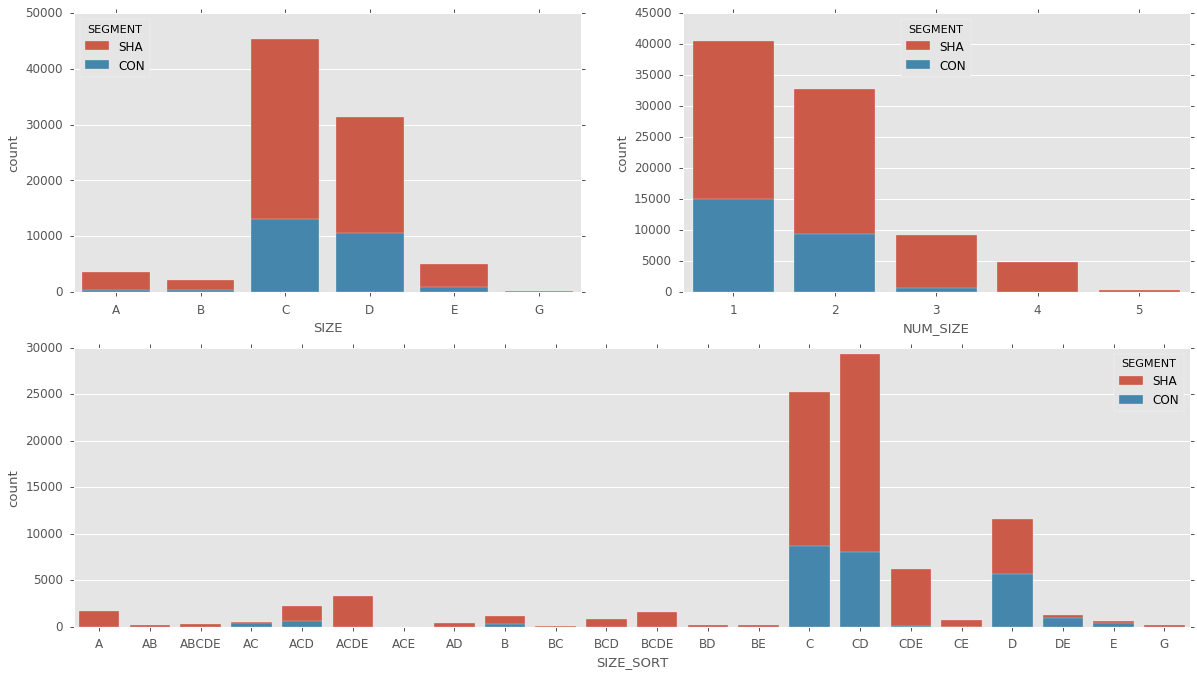

In [14]:
fig = plt.figure(figsize = [20, 11])
ax1 = fig.add_subplot(221)
sns.countplot(x = 'SIZE', hue = 'SEGMENT', data = tab.sort_values(by = 'SIZE'), ax = ax1, dodge = False)
ax2 = fig.add_subplot(222)
sns.countplot(x = 'NUM_SIZE', hue = 'SEGMENT', data = tab.sort_values(by = 'NUM_SIZE'), ax = ax2, dodge = False)
ax3 = fig.add_subplot(212)
sns.countplot(x = 'SIZE_SORT', hue = 'SEGMENT', dodge = False, ax = ax3, data = tab.sort_values(by = 'SIZE_SORT'))

Create (a reference to) a subset of tab, containing only the SIZE_SORT values of interest:

In [15]:
tab2 = tab[tab.SIZE_SORT.isin(['C', 'D', 'E', 'CD', 'CDE'])]

### Dependency of SALES to promotions ###
PCTF and PCTD are similar to PCT and contain the percentage of stores where a product was _'Featured'_ or _'Displayed'_.  
Both featuring and display can hold for a product.  
  
A __featured__ product is a product sold with an extra 'feature' like another complementary product attched to it (e.g. shampoo with conditioner)  
A __displayed__ product is placed in a spoting location in the store  
  
In the following we examine the relation of PCTD with SALES and display this relationship visually and with a statistical descriptive measure called __'lift'__

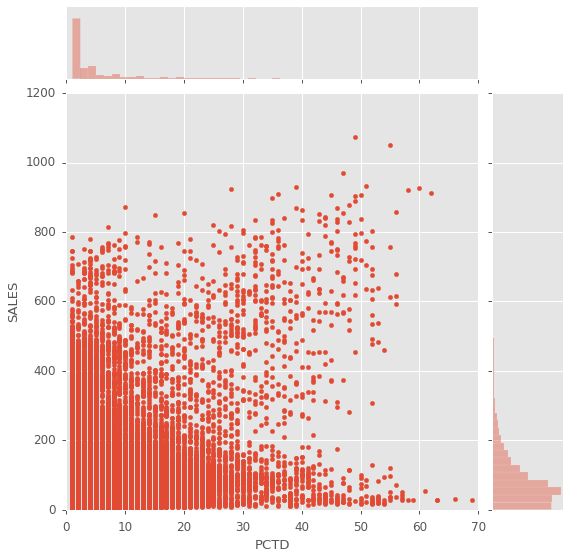

In [16]:
_ = sns.jointplot(x = 'PCTD', y = 'SALES', data = tab2[tab2.PCTD > 0.], size = 8, stat_func = None)

<div style = "color: darkred; font-size: 200%; font-weight: bold;  text-decoration: underline"> 
Exercise 
</div>  
  
A lift of a scalar quantity (here SALES) wrt a binary variable V is defined as:  
$$\frac{\mathtt {AVG(quantity)\, for\, V = 1}}{\mathtt {AVG(quantity)\, for\, V = 0}}$$

Calculate the lift of sales for PCTD > .2 versus PCTD <= .2


### Elaborating on SIZE_SORT ###
The relation of the size composition of a sort to sort's sales is a bit involved.  
  
A question is:  
'Given that a size is available for sale, what size sorts (containing this size) sell more?'
  
The following diagram uses seaborn's ploting tools to display a breakdown of AVG sales per SIZE_SORT for each combination of BRAND and SIZE
There's visual evidence that the co-existence CD and CDE increases AVG SALES.

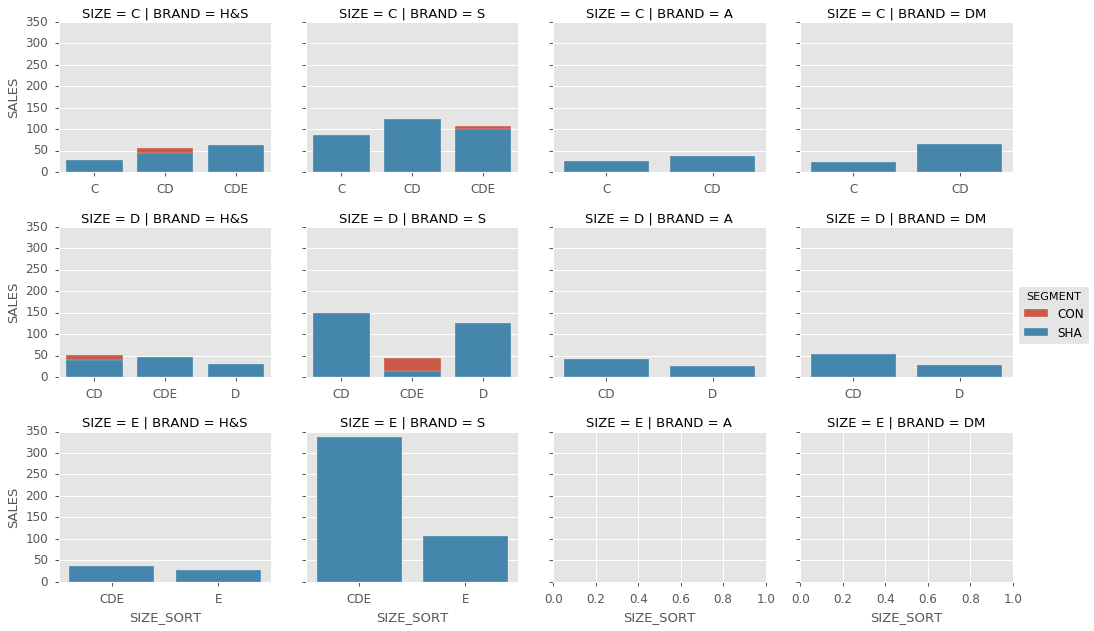

In [17]:
tab3 = tab2.groupby(['SEGMENT', 'BRAND', 'SIZE', 'SIZE_SORT'], as_index = False)['SALES'].mean()
fg = sns.FacetGrid(
    tab3,
    row = 'SIZE', col = 'BRAND', hue = 'SEGMENT', size = 3., aspect = 1.2, sharex = False)
_ = fg.map(sns.barplot, 'SIZE_SORT', 'SALES').add_legend()

-------------------------
# Conclusions #

DataFrames and matplotlib-seaborn systems are very powerful for doing EDA on moderately-sized datasets.  
the problem is that the data must reside in memory, however this is easily aleviated using PySpark or increasing the available memory.  
  
Beyond the technical matters, __the most important caveat of visual analysis and descriptive stats is that:__    
<span style = "background: #E9B96E">
In the real world there're __usually NO straightforward relationships among a few features__.  
In the 'retailer' dataset we saw that there's an increase in sales for certain size combinations in relation with others,  
but this does not hold globaly.  
Moreover we haven't yet seen if this happens irrespective of time of if there're certain periods where this happens.  
And what about the possible dependency to location?  
<br>
Most of the examples you see in MOOCs and elsewhere use datasets with obvious relations between a few fields in the observations.  
This is acceptable for demonstrating the capabilities of a library or a visualization. 
In practive however, the dependencies are more complex and involve __many__ fields so that it is  
difficult to discover them explicitly using visualizations.
</span>  
  
this is where __Machine Learning__ comes in:  
We let an algorithm find interactions among multiple fields and rest with the fact that this is __better than an eye can do__  
  
Below we'll see that it is preferable to employ a regression tree to do a whatif analysis automatically for any size assortment, brand, promo and week we like

--------------------------------

# Machine Learning #

In [19]:
wsgKey = ['WEEK_ENDING', 'SORT', 'GEO']
wsgDict = {
    'WEEK': 'first', 'BRAND': 'first', 'TYPE': 'first', 'COLLECTION': 'first', 
    'SALES': 'mean'}
wsgDf = tab.groupby(wsgKey).agg(wsgDict)

In [21]:
# 3. Create (WEEK_ENDING, SORT, GEO, SIZE)-level features
wsgsKey = ['WEEK_ENDING', 'SORT', 'GEO', 'SIZE']
fields = ['PRICE', 'PCTD', 'PCTF']
wsgsDf = tab.groupby(wsgsKey)[fields].agg('mean')

In [22]:
# 4. unstack SIZE and rename affected fields
wsgsDf = wsgsDf.unstack(level = 'SIZE', fill_value = 0)
wsgsDf.columns = ['-'.join(v) for v in wsgsDf.columns.ravel()]

# 5. merge wsgDf and wsgsDf and save merged
xyAll = pd.merge(wsgsDf, wsgDf, left_index = True, right_index = True)


In [23]:
xyAll.to_csv('retailerML.csv', sep = '|')

In [24]:
xAll = xyAll.drop(labels = 'SALES', axis = 'columns').reset_index(level = ['SORT', 'GEO'])
yAll = xyAll.SALES

In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

def dataFrameEncode(df_):
    _le = LabelEncoder()
    return pd.DataFrame(data = {col: _le.fit_transform(df_[col]) for col in df_.columns}, index = df_.index)


In [29]:
objectCols = xAll.dtypes[xAll.dtypes == 'object'].index
xAll[objectCols] = dataFrameEncode(xAll[objectCols])
xTrain, xTest, yTrain, yTest = train_test_split(xAll, yAll, test_size = .3)

### Gradient boosted regressor ###
---------------------------------------

In [36]:
gbr = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = 12), n_estimators = 40)
gbr.fit(xTrain, yTrain)
print 'rfrTestScore:', gbr.score(xTest, yTest)
gbrPredictions = gbr.predict(xTest)

rfrTestScore: 0.936104397463


### Random forest regressor ###
------------------------------------

In [35]:
rfr = RandomForestRegressor()
rfr.fit(xTrain, yTrain)
print 'rfrTestScore:', rfr.score(xTest, yTest)
rfrPredictions = rfr.predict(xTest)

rfrTestScore: 0.943099499737


### Plots ###

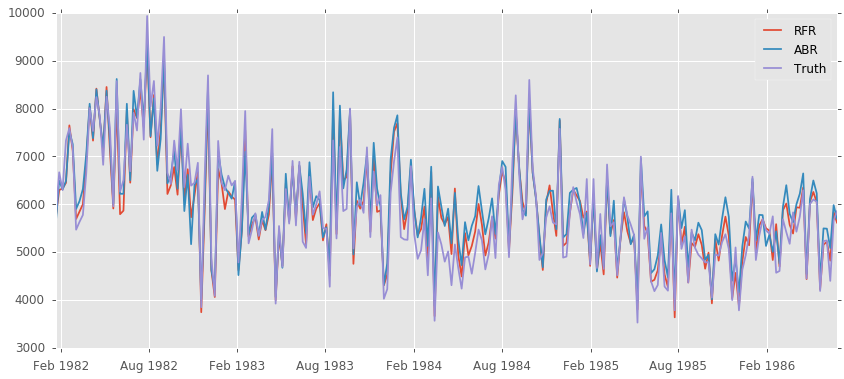

In [41]:
fitDf = pd.DataFrame(
    data = np.column_stack([rfrPredictions, gbrPredictions]), 
    columns = ['RFR', 'ABR'], 
    index = yTest.index)
fitDf['SALES'] = yTest

fig = plt.figure(figsize = (14, 6)); 
ax = fig.add_subplot(111)
lines = ax.plot(fitDf.groupby('WEEK_ENDING').sum())
ax.legend(lines, ('RFR', 'ABR', 'Truth'))